# Лабораторная работа №7 Исследование изображений сверточными нейронными сетями
Пан Анатолий Эдуардович<br>
Группа 932209<br>
Вариант 1 - Идентификация дефектов в трубах с использованием сверточных нейронных сетей (трещины)

## Подключаем kaggle и Google Drive для импорта набора данных

In [1]:
# Install kaggle
!pip install -q kaggle

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/Nauchka")

In [4]:
# Create a kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to created folder
!cp kaggle.json ~/.kaggle/

In [5]:
os.chdir("/content")

In [6]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

## Импорт необходимых библиотек и модулей

In [7]:
from zipfile import ZipFile
from tqdm import tqdm

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Скачивание и распаковка набора данных

In [9]:
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

 98% 56.0M/57.4M [00:03<00:00, 23.4MB/s]
100% 57.4M/57.4M [00:03<00:00, 16.1MB/s]


In [10]:
# Unzip our dataset
file_to_extract = "neu-metal-surface-defects-data.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in zip_file.namelist():
        zip_file.extract(member=file)

Используем GPU

In [11]:
!nvidia-smi

Wed Nov  1 09:10:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Предобработка данных

Постоянные значения

In [31]:
width = 200
height = 200
color = 3
batch_size = 32

Пути к выборкам

In [152]:
train_dir = "NEU Metal Surface Defects Data/train"
test_dir = "NEU Metal Surface Defects Data/test"
val_dir = "NEU Metal Surface Defects Data/valid"

ImageDataGenerator позволяет легко маркировать и загружать большие наборы данных изображений. Здесь мы создаем два объекта для ImageDataGenerator, а также масштабируем изображение так, чтобы значения их пикселей были нормализованы между 0 и 1, не влияя на качество изображения, что облегчит обучение CNN

In [153]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                #    rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

Затем мы используем эти объекты для вызова метода потока из каталога, указывая путь к каталогу обучения и тестирования, целевой размер, который важен, поскольку реальные изображения могут быть разного размера, поэтому, каким бы ни был размер входного изображения, он будет изменен до 200х200 px. Затем мы указываем размер батча, который просто означает количество образцов, которые будут распространяться по сети в данный момент времени

In [154]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(width, height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = test_datagen.flow_from_directory(val_dir,
                                                   target_size=(width, height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(width, height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


Проверим классы

In [122]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())
class_names

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

Перевод на русский язык:

['трещины', 'вкрапления', 'пятна', 'ямки', 'накаты', 'царапины'].

Посмотрим на несколько изображений из обучающей выборки

In [123]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]
    return image, label_name

In [124]:
def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

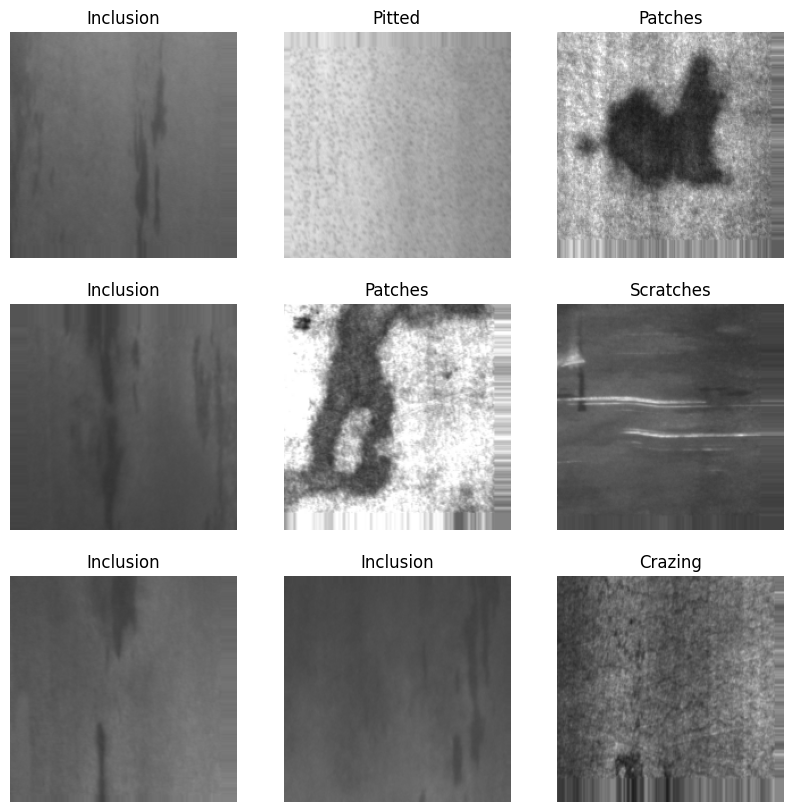

In [125]:
sample_images(train_generator, nrows=3, ncols=3)

## Построение CNN

In [126]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [127]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 23, 23, 128)     

Если не будет никаких изменений валидационной точности в течении 7 эпох, то остановим обучение

In [129]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1
                           )

checkpoint = ModelCheckpoint('defects_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True
                             )

callbacks_list=[early_stop, checkpoint]

In [130]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 1.8049 - accuracy: 0.2566
Epoch 1: val_accuracy improved from -inf to 0.18056, saving model to defects_weights-01-0.181.hdf5
52/52 [==============================] - 22s 388ms/step - loss: 1.8049 - accuracy: 0.2566 - val_loss: 1.4961 - val_accuracy: 0.1806
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 1.1747 - accuracy: 0.5519
Epoch 2: val_accuracy improved from 0.18056 to 0.76389, saving model to defects_weights-02-0.764.hdf5
52/52 [==============================] - 24s 462ms/step - loss: 1.1747 - accuracy: 0.5519 - val_loss: 0.8122 - val_accuracy: 0.7639
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.7956 - accuracy: 0.7114
Epoch 3: val_accuracy improved from 0.76389 to 0.86111, saving model to defects_weights-03-0.861.hdf5
52/52 [==============================] - 23s 437ms/step - loss: 0.7956 - accuracy: 0.7114 - val_loss: 0.4207 - val_accuracy: 0.8611
Epoch 4/50
52/52 [=

Визуализируем результаты. Построим графики зависимости потерь и точности от количества эпох

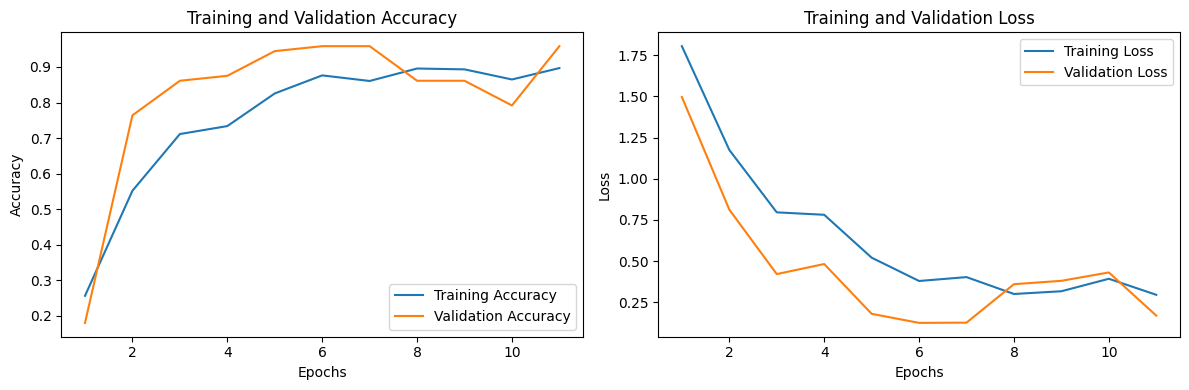

In [131]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Оценка наилучшей модели

In [155]:
model.load_weights("defects_weights-06-0.958.hdf5")

In [156]:
result = model.evaluate(test_generator)

3/3 [==============================] - 0s 26ms/step - loss: 0.5566 - accuracy: 0.7917


Предсказание на тестовом наборе

In [157]:
images, labels = next(test_generator)
indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

In [158]:
predictions = model.predict(images)

1/1 [==============================] - 0s 20ms/step


Визуальное представление

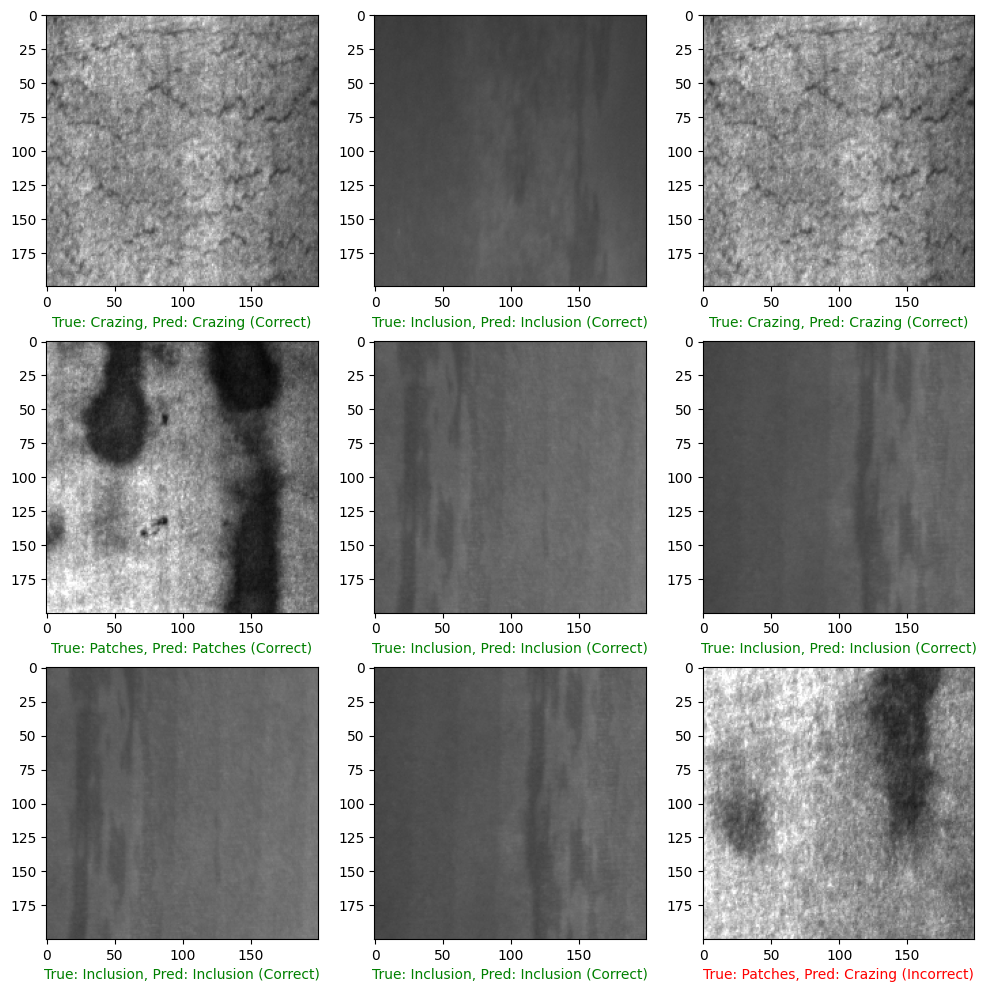

In [159]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color="green"
        result_text="Correct"
    else:
        color="red"
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text, color=color)